In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
from scipy.optimize import minimize
import pdb
import statsmodels.api as sm
from matplotlib import rc
rc('text', usetex=True)

In [2]:
%matplotlib inline

## Question 1

### (a)

See below.

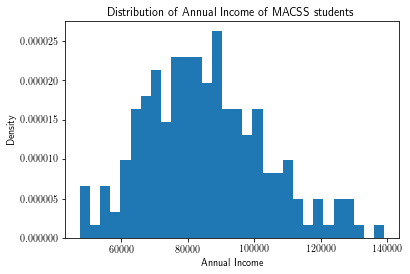

In [3]:
dt = np.loadtxt("incomes.txt")
fig, ax = plt.subplots()
ax.hist(dt, normed = True, bins= 30)
ax.set(title = "Distribution of Annual Income of MACSS students", 
       xlabel = "Annual Income", 
        ylabel = "Density")
plt.show()

### (b)

First, let's construct a general-purpose GMM framework.

In [4]:
class GMM:
    def __init__(self):
        pass
    
    def model_moment(self, param):
        pass
    
    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)/self.data_moment
        return e.T @ W @ e
    
    def vcv(self, param):
        e = (self.model_moment(param) - self.data_moment)/self.data_moment
        return e @ e.T / self.N
    
    def estimate(self, init, method = "identity", bounds = None):
        results = minimize(self.error_func, init, method='L-BFGS-B', bounds = bounds)
        if method == "identity":
            return results
        if method == "two-step":
            e = (self.model_moment(results.x) - self.data_moment)/self.data_moment
            vcv = e @ e.T / self.N
            W = np.linalg.inv(vcv)
            W = W/np.sum(W) # rescale the W in case of overflow
            results = minimize(self.error_func, results.x, args = W, method='L-BFGS-B',  bounds = bounds)
            return results
        if method == "iterate":
            W = np.eye(len(init))
            while True:
                e = (self.model_moment(results.x) - self.data_moment)/self.data_moment
                vcv = e @ e.T / self.N
                new_W = np.linalg.inv(vcv)
#                 new_W = new_W/np.sum(new_W) # rescale the W in case of overflow    
                if np.sum(np.abs(new_W - W))>1e-7:
                    W = new_W
                    results = minimize(self.error_func, results.x, args = (W), method='L-BFGS-B',  bounds = bounds)
                else:
                    return results    

Then I construct a child class tailored for the estimation of Log Normal distribution.

Note that in order to minimize the numerical error and computation overload, I did not use integration to calculate the moment. Thanks to the simplicity of the log normal distribution, I use analytical expression to directly obtain the moments.

In [5]:
class Log_Normal(GMM):
    def __init__(self, data):
        self.N = len(data)
        self.data = data
        self.data_moment = np.array((np.mean(self.data), np.std(self.data))).reshape((2,1))
        
    def model_moment(self, param):
#       Given the formula of model moment is easily calculated analytically,
#       I use the expression directly here instead of numerical integral to avoid inaccuracy and addtional offhead.
        param = np.array(param).reshape(2, 1)
        mean = np.exp(np.array((1, 0.5)).reshape((1,2)) @ param)
        std = np.sqrt(np.exp(np.array((2, 1)).reshape((1,2)) @ param) * (np.exp(param[1,:]) - 1))
        return np.concatenate((mean, std), axis = 0)
    
    def pdf(self, x, param):
        mu, sigma2 = param
        sigma = np.sqrt(sigma2)
        return 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma/sigma)

In [6]:
ln = Log_Normal(dt)
results = ln.estimate((11, 0.2), bounds = ((None, None), (1e-10, None)))

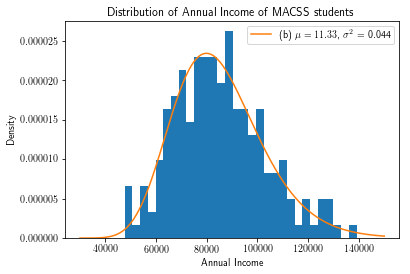

In [7]:
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results.x)
ax.plot(x, y, label = "(b) $\mu= {}$, $\sigma^2$ = {}$".format(round(results.x[0], 2),
                                                            round(results.x[1], 3)))
ax.legend()
fig

In [8]:
print("The estimated mu = {}, and sigma = {}: ".format(results.x[0], np.sqrt(results.x[1])))
print("The value of criterion function at the estimated paramter values is:")
print(results.fun[0])
print("Two data momments is ")
print(ln.data_moment)
print("Two model moment is ")
print(ln.model_moment(results.x))


The estimated mu = 11.33188203192565, and sigma = 0.20869644276782326: 
The value of criterion function at the estimated paramter values is:
[  1.31026882e-12]
Two data momments is 
[[ 85276.82360626]
 [ 17992.54212805]]
Two model moment is 
[[ 85276.92103295]
 [ 17992.54340264]]


Model moments and data moments are very close.

### (c)

two-step is implemented as a method in the class defined above.

Also note that in order to avoid numerical overflow, I rescaled the weight matrix. This manipulation will not influence the accuracy of the results.

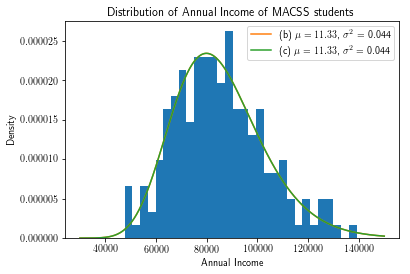

In [9]:
results2 =  ln.estimate((11, 0.2), method = "two-step", bounds =  ((None, None), (1e-10, None)))
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results2.x)
ax.plot(x, y, label = "(c) $\mu= {}$, $\sigma^2$ = {}$".format(round(results2.x[0], 2),
                                                            round(results2.x[1], 3)))
ax.legend()
fig

In [10]:
print("The estimate for mu and sigma^2 is: ")
print(results2.x)
print("The value of criterion function at the estimated paramter values is:")
print(results2.fun[0])
print("Two data momments is ")
print(ln.data_moment)
print("Two model moment is ")
print(ln.model_moment(results2.x))

The estimate for mu and sigma^2 is: 
[ 11.33188203   0.04355421]
The value of criterion function at the estimated paramter values is:
[  2.19192847e-30]
Two data momments is 
[[ 85276.82360626]
 [ 17992.54212805]]
Two model moment is 
[[ 85276.92103295]
 [ 17992.54340264]]


Actually, it seems that two-step method generates the same results as the naive one.

I also implemented a iterative version, which yields the same result. See below.

In [11]:
results3 = ln.estimate((11, 0.2), method = "iterate", bounds = ((None, None), (1e-10, None)))

In [12]:
results3.x

array([ 11.33188203,   0.04355421])

### (d)

Here we defined another Log_normal class equipped with new moments.

In [13]:
from scipy.stats import norm
class Log_Normal2(Log_Normal):
    def __init__(self, data):
        self.N = len(data)
        self.data = data
        data = np.array(data)
        m1 = sum(data<75000)/len(data)
        m2 = np.all((data>=75000, data<=100000), axis = 0).sum()/len(data)
        m3 = sum(data>100000)/len(data)
        self.data_moment = np.array((m1,m2,m3)).reshape((3,1))
        
    def model_moment(self, param):
#       Given the formula of model moment is easily calculated analytically,
#       I use the expression directly here instead of numerical integral to avoid inaccuracy and addtional offhead.
        mu, sigma2 = param
        m1 = norm.cdf(np.log(75000), loc = mu, scale = np.sqrt(sigma2))
        m2 = norm.cdf(np.log(100000), loc = mu, scale = np.sqrt(sigma2)) - m1
        m3 = 1 - norm.cdf(np.log(100000), loc = mu, scale = np.sqrt(sigma2))
        return np.array((m1,m2,m3)).reshape((3,1))
    

In [14]:
ln2 = Log_Normal2(dt)
results4 = ln2.estimate((11, 0.5), bounds = ((None, None), (1e-10, None)))

In [15]:
print("The estimate for mu and sigma^2 is: ")
print(results4.x)
print("The value of criterion function at the estimated paramter values is:")
print(results4.fun[0])
print("Two data momments is ")
print(ln2.data_moment)
print("Two model moment is ")
print(ln2.model_moment(results4.x))

The estimate for mu and sigma^2 is: 
[ 11.33568135   0.04435173]
The value of criterion function at the estimated paramter values is:
[  1.54207482e-13]
Two data momments is 
[[ 0.3]
 [ 0.5]
 [ 0.2]]
Two model moment is 
[[ 0.30000002]
 [ 0.49999991]
 [ 0.20000007]]


The model moments are also very close to the data moments.

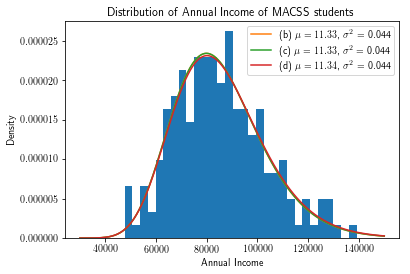

In [16]:
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results4.x)
ax.plot(x, y, label = "(d) $\mu= {}$, $\sigma^2$ = {}$".format(round(results4.x[0], 2),
                                                            round(results4.x[1], 3)))
ax.legend()
fig

### (e)

In [17]:
results5 = ln2.estimate((11, 0.5), method = "two-step", bounds = ((None, None), (1e-10, None)))

In [18]:
print("The estimate for mu and sigma^2 is: ")
print(results5.x)
print("The value of criterion function at the estimated paramter values is:")
print(results5.fun[0])
print("Two data momments is ")
print(ln2.data_moment)
print("Two model moment is ")
print(ln2.model_moment(results5.x))

The estimate for mu and sigma^2 is: 
[ 11.33568135   0.04435173]
The value of criterion function at the estimated paramter values is:
[  1.89767444e-31]
Two data momments is 
[[ 0.3]
 [ 0.5]
 [ 0.2]]
Two model moment is 
[[ 0.30000002]
 [ 0.49999991]
 [ 0.20000007]]


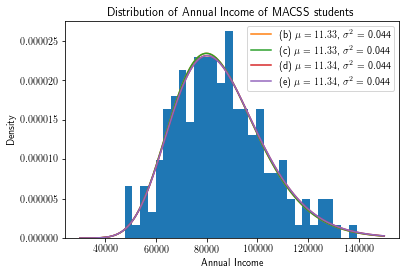

In [19]:
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results5.x)
ax.plot(x, y, label = "(e) $\mu= {}$, $\sigma^2$ = {}$".format(round(results4.x[0], 2),
                                                            round(results4.x[1], 3)))
ax.legend()
fig

The results are the same as those in (d).

## (f)

Theoretically, both set of moments are all valid: both sample moments are consistent and unbiased estimators for model moments, so they satisfy the GMM's conditions.

In practice, given their estimations are very close and fit the data quite well according to the figures and the criterion functions, it might not be very beneficial to argue which one is better.

For the answer of this question, let's print the variance-covariance matrix and check which one yields smaller errors.

In [20]:
print(ln.vcv(results.x))
print(ln.vcv(results2.x))
print(ln2.vcv(results4.x))
print(ln2.vcv(results5.x))

[[  6.52625239e-15   4.04666219e-16]
 [  4.04666219e-16   2.50916972e-17]]
[[  6.52625239e-15   4.04666219e-16]
 [  4.04666219e-16   2.50916972e-17]]
[[  1.71657426e-17  -5.09777634e-17   1.01695795e-16]
 [ -5.09777634e-17   1.51390617e-16  -3.02009897e-16]
 [  1.01695795e-16  -3.02009897e-16   6.02481050e-16]]
[[  1.71657426e-17  -5.09777634e-17   1.01695795e-16]
 [ -5.09777634e-17   1.51390617e-16  -3.02009897e-16]
 [  1.01695795e-16  -3.02009897e-16   6.02481050e-16]]


It shows that the second set of moments (d) (e) has smaller estimation errors, so they fit the model best. In between these two, I will choose the two-step method. Though the results are the same for this problem, two-step method ought to generate better estimators by design.

### Appendix

To validate our results above, I choose $\mu$ and $\sigma^2$ as the target moments and do the estimate. This is very close to the typical moment estimation.

In [21]:
class Log_Normal3(Log_Normal):

    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)
        return e.T @ W @ e
    
    def __init__(self, data):
        self.N = len(data)
        logdata = np.log(data)
        self.data_moment = np.array([[logdata.mean()], [logdata.var()]])
        
    def model_moment(self, param):
        return np.array(param).reshape((2,1))

In [22]:
ln3 = Log_Normal3(dt)
ln3.estimate((11, 1), bounds = ((None, None), (1e-10, None)))

      fun: array([[  2.18451039e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.03720454e-08,  -1.14192419e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 2
   status: 0
  success: True
        x: array([ 11.33144033,   0.04480612])

The same as hour first GMM results.

## Part 2

In [23]:
import pandas as pd
sick = pd.read_csv("sick.txt")

### (a)

Let's construct a Linear_Regression subclass under the same framework used for the first question.

In [24]:
class Linear_Regression(GMM):
    
    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)
        return e.T @ W @ e
    
    def __init__(self, data):
        self.data = data.values
        self.N = self.data.shape[0]
        self.data_moment = data.iloc[:,0].values
    
    def model_moment(self, param):
        param = np.array(param)
        X = np.concatenate((np.ones((self.N,1)),self.data[:,1:]), axis = 1)
        return X @ param

In [25]:
lr = Linear_Regression(sick)
res = lr.estimate((1,1,1,1))

In [26]:
print("The estimate for beta_0 to beta_3 is: ")
print(res.x)
print("The value of criterion function at the estimated paramter values is:")
print(res.fun)

The estimate for beta_0 to beta_3 is: 
[ 0.25164422  0.0129334   0.40050162 -0.00999164]
The value of criterion function at the estimated paramter values is:
0.00182128982614


The same results as Problem set 2.